In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Sampler
import numpy as np
import cv2 as cv
import torchlayers as tl
import os
from torchvision.utils import save_image

In [2]:
trans = transforms.Compose([
    transforms.Resize((120, 120)), 
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
trans_gray = transforms.Compose([transforms.Resize((120, 120)), transforms.ToTensor(), transforms.Grayscale(3)])


# datas = torchvision.datasets.ImageFolder(root = './data/kcar/darks', transform = trans)
# train_size = int(len(datas) * 0.8)
# test_size = len(datas) - train_size
# train_sets, test_sets = torch.utils.data.random_split(datas, [train_size, test_size])

# edge_datas = torchvision.datasets.ImageFolder(root = './data/kcar_edge/darks', transform = trans_gray)
# edge_train_size = int(len(edge_datas) * 0.8)
# edge_test_size = len(edge_datas) - edge_train_size
# edge_train_sets, edge_test_sets = torch.utils.data.random_split(edge_datas, [edge_train_size, edge_test_size])

# edge_train_sets = torchvision.datasets.ImageFolder(root = './data/kcar_edge/lights', transform = trans_gray)
edge_img_sets = torchvision.datasets.ImageFolder(root = './data/tiny-imagenet-200/edge2', transform = trans_gray)
# train_sets = torchvision.datasets.ImageFolder(root = './data/kcar/lights', transform = trans)
img_sets = torchvision.datasets.ImageFolder(root = './data/tiny-imagenet-200/train', transform = trans)
labels = img_sets.classes
print("edge_train_sets  :", len(edge_img_sets))
print("train_sets       :", len(img_sets))
# print(test_sets)
# print(edge_test_sets)


edge_train_sets  : 100000
train_sets       : 100000


In [3]:
# DataLoader 정의 - data 길이 달라지면 random_t_list 수정하기!
import random
train_size = int(len(img_sets) * 0.8)
test_size = len(img_sets) - train_size

random_train_list = list(range(1, train_size))
random.shuffle(random_train_list)
random_test_list = list(range(1, test_size))
random.shuffle(random_test_list)

train_loader = DataLoader(img_sets, batch_size = 32, num_workers = 2, sampler = random_train_list)
edge_train_loader = DataLoader(edge_img_sets, batch_size = 32, num_workers = 2, sampler = random_train_list)
test_loader = DataLoader(img_sets, batch_size = 32, sampler = random_test_list)
edge_test_loader = DataLoader(edge_img_sets, batch_size = 32, sampler = random_test_list)

print(len(train_loader))

2500


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')
print(torch.cuda.is_available())
torch.cuda.empty_cache()

cuda:0 is available
True


n01629819


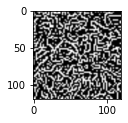

n01629819


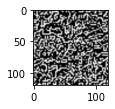

n01629819


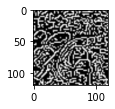

n01629819


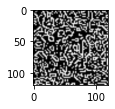

In [5]:
for i in range(4):
    img, label = edge_img_sets[i+600]
    print(labels[label])
    plt.subplot(241 + i)
    plt.imshow(np.clip(img.permute(1,2,0),0,1))
    plt.tight_layout()
    plt.show()

In [6]:
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
 
        _, pred = output.topk(maxk, 1, True, True) #(52, 32)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred)) # (5,32)
 
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [5]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        # self.maxPool = nn.MaxPool1d(3, stride=2)
        self.fc1 = nn.Linear(1000, 200)
        self.fc2 = nn.Linear(1000, 200)
        self.fc3 = nn.Linear(400, 200)
        
    def forward(self, x1, x2):
        x1 = self.modelA(x1)
        # x1 = self.maxPool(x1)
        x1 = self.fc1(x1)

        x2 = self.modelB(x2)
        # x2 = self.maxPool(x2)
        x2 = self.fc2(x2)

        x = torch.cat((x1, x2), dim=1)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):  
        size = x.size()[1:] 
        num_features = 1 
        for s in size: 
            num_features *= s 
        return num_features

resnet101 = torchvision.models.resnet101(pretrained=False)
resnet101 = resnet101.cuda()

resnet101_edge = torchvision.models.resnet101(pretrained=False)
resnet101_edge = resnet101_edge.cuda()

model = MyEnsemble(resnet101, resnet101_edge)
model = model.cuda()
print("model created!")

model created!


In [11]:
#MyEnsemble 모델 학습 dark version
print(len(train_loader))
print(len(test_loader))

criterion = torch.nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,6,8], gamma=0.1)
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# hyper-parameters
num_epochs = 10
num_batches = 32

model.train()
max_acc = 30
saved_trn_acc = 0

trn_loss_list = []
val_loss_list = []
for epoch in range(num_epochs):
    trn_loss = 0.0
    total = 0
    correct = 0
    try:
        for i, (data, edge_data) in enumerate(zip(train_loader, edge_train_loader)):
            x, label = data
            x2, label2 = edge_data

            x = x.cuda()
            label = label.cuda()
            x2 = x2.cuda()
            # grad init
            optimizer.zero_grad()
            # forward propagation
            model_output = model(x, x2)
            _, predicted = torch.max(model_output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            # calculate loss
            loss = criterion(model_output, label)
            # back propagation
            loss.backward()
            # weight update
            optimizer.step()

            # trn_loss summary
            trn_loss += loss.item()

            # 학습과정 출력
            if (i+1) % 500 == 1:  # every 100 mini-batches
                model.eval()
                with torch.no_grad():  # very very very very important!!!
                    val_loss = 0.0
                    val_total = 0
                    val_correct = 0
                    count = 0
                    for j, (val, edge_val) in enumerate(zip(test_loader, edge_test_loader)):
                        val_x, val_label = val
                        val_x2, val_label2 = edge_val
                        val_x = val_x.cuda()
                        val_x2 = val_x2.cuda()
                        val_label = val_label.cuda()

                        val_output = model(val_x, val_x2)
                        _, predicted = torch.max(val_output.data, 1)
                        val_total += val_label.size(0)
                        val_correct += (predicted == val_label).sum().item()
                        v_loss = criterion(val_output, val_label)
                        val_loss += v_loss
                        count += 1
                        if count < 2 and ((100 * val_correct / val_total) < max_acc or (100 * correct / total) < 90) :
                            break
                    # print("----------------testing data: " +
                        # str(j * len(test_loader)))
                    # acc1, acc5 = accuracy(model_output, label, topk=(1, 5))
                    # print("train acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
                    # print('Accuracy of the network on the train images: %f %%' %
                        # (100 * correct / total))
                    # acc1, acc5 = accuracy(val_output, val_label, topk=(1, 5))
                    # print("test acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
                    # print('Accuracy of the network on the test images: %f %%' %
                        # (100 * val_correct / val_total))
                    print('{}: train: {:.4f}%, test: {:.4f}%'.format(j * len(test_loader), (100 * correct / total), (100 * val_correct / val_total)))

                    if (100 * correct / total) > 90 and (100 * val_correct / val_total) > max_acc:
                        max_acc = (100 * val_correct / val_total)
                        saved_trn_acc = (100 * correct / total)

                print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                    epoch+1, num_epochs, i+1, len(train_loader), trn_loss / len(train_loader), val_loss / len(test_loader)))
                print("-----------------max accuracy : {:.4f}, train acc : {:.4f}--------------".format(max_acc, saved_trn_acc))

                trn_loss_list.append(trn_loss/len(train_loader))
                val_loss_list.append(val_loss/ len(test_loader))
                # val_loss_list.append(val_loss/len(test_loader))
                trn_loss = 0.0
                model.train()

            # del (memory issue)
            # del lossadw
            del model_output
    except (OSError) as e:
        print(e)
    #scheduler.step()
#plotting the loss chart 


2500
625
0: train: 75.0000%, test: 40.6250%
epoch: 1/10 | step: 1/2500 | trn loss: 0.0002 | val loss: 0.0051
-----------------max accuracy : 30.0000, train acc : 0.0000--------------
0: train: 86.9386%, test: 46.8750%
epoch: 1/10 | step: 501/2500 | trn loss: 0.0827 | val loss: 0.0040
-----------------max accuracy : 30.0000, train acc : 0.0000--------------
0: train: 87.3377%, test: 46.8750%
epoch: 1/10 | step: 1001/2500 | trn loss: 0.0784 | val loss: 0.0039
-----------------max accuracy : 30.0000, train acc : 0.0000--------------
0: train: 87.4375%, test: 46.8750%
epoch: 1/10 | step: 1501/2500 | trn loss: 0.0770 | val loss: 0.0053
-----------------max accuracy : 30.0000, train acc : 0.0000--------------
0: train: 87.5859%, test: 46.8750%
epoch: 1/10 | step: 2001/2500 | trn loss: 0.0758 | val loss: 0.0044
-----------------max accuracy : 30.0000, train acc : 0.0000--------------
0: train: 87.5000%, test: 31.2500%
epoch: 2/10 | step: 1/2500 | trn loss: 0.0001 | val loss: 0.0044
----------

KeyboardInterrupt: 

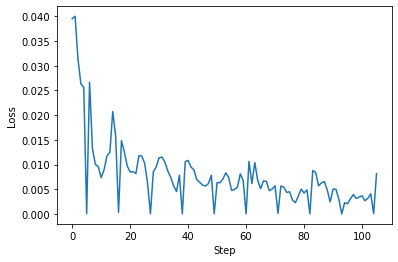

In [ ]:

# plt.plot([x in x.cpu() from trn_loss_list])
plt.plot(trn_loss_list[6:])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

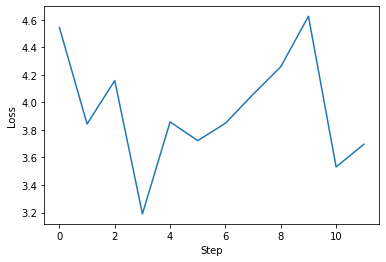

In [ ]:

# plt.plot([x in x.cpu() from trn_loss_list])
val = []
for l in val_loss_list:
    val.append(l.cpu())
plt.plot(val)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

In [12]:
torch.save(model, 'parallel_cnn_tiny_52.18%.pt')

In [6]:
model = torch.load('parallel_cnn_tiny%.pt')

In [ ]:
_cnn_tiny%.pt')

In [ ]:
#MyEnsemble 모델 학습 dark version
print(len(train_loader))
print(len(test_loader))
criterion = nn.CrossEntropyLoss()
# backpropagation method
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# hyper-parameters
num_epochs = 10
num_batches = 32

model.train()
trn_loss_list = []
val_loss_list = []
for epoch in range(num_epochs):
    trn_loss = 0.0
    for i, (data, edge_data) in enumerate(zip(train_loader, edge_train_loader)):
        x, label = data
        x2, label2 = edge_data

        x = x.cuda()
        label = label.cuda()
        x2 = x2.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        model_output = model(x, x2)
        # calculate loss
        loss = criterion(model_output, label)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        
        # 학습과정 출력
        if (i+1) % 100 == 1: # every 100 mini-batches
            model.eval()
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                for j, (val, edge_val) in enumerate(zip(test_loader, edge_test_loader)):
                    val_x, val_label = val
                    val_x2, val_label2 = edge_val
                    val_x = val_x.cuda()
                    val_x2 = val_x2.cuda()
                    val_label =val_label.cuda()
                    val_output = model(val_x, val_x2)
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss
                    if j > 50 * epoch:
                        print("testing data: "+ str(j * len(test_loader)))
                        break
                       
            print("trn loss: {:.4f} | val loss: {:.4f}".format(
                trn_loss / 100, val_loss / len(test_loader)
            ))
            acc1, acc5 = accuracy(model_output, label, topk=(1, 5))
            print("acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
                    
            
            trn_loss_list.append(trn_loss/100)
            val_loss_list.append(val_loss/len(test_loader))
            trn_loss = 0.0
            model.train()
        
        # del (memory issue)
        del loss
        del model_output

213
54
testing data: 54
trn loss: 0.0007 | val loss: 0.0138
acc1 : 96.875, acc5 : 100.0
testing data: 54
trn loss: 0.1050 | val loss: 0.0197
acc1 : 100.0, acc5 : 100.0
testing data: 54
trn loss: 0.0958 | val loss: 0.0152
acc1 : 93.75, acc5 : 100.0
testing data: 2754
trn loss: 0.0003 | val loss: 0.4240
acc1 : 100.0, acc5 : 100.0


KeyboardInterrupt: 

In [ ]:
# MyEnsemble 테스트
model.eval()
correct = 0
total = 0
class_correct = np.zeros(51)
class_total = np.zeros(51)
count = 0
print(len(test_loader))
print(len(labels))
with torch.no_grad():
    for index, ((images, targets), (edge_images, edge_target)) in enumerate(zip(test_loader, edge_test_loader)):
        images = images.cuda()
        edge_images = edge_images.cuda()
        targets = targets.cuda()

        outputs = model(images, edge_images)
        _, predicted = torch.max(outputs.data, 1)
        acc1, acc5 = accuracy(outputs, targets, topk=(1, 5))
        print("acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        c = (predicted == targets).squeeze()
        count += 1
        for i in range(32):
            target = targets[i]
            class_correct[target] += c[i].item()
            class_total[target] += 1
        if count > len(test_loader)/10:
            break
            
for i in range(51):
    print('Accuract of %5s : %2d %%' %(
        labels[i], 100 * class_correct[i] / class_total[i]))
        
print('Accuracy of the network on the test images: %f %%' % (
      100 * correct / total))

271
51
acc1 : 31.25, acc5 : 53.125
acc1 : 28.125, acc5 : 53.125
acc1 : 25.0, acc5 : 68.75
acc1 : 34.375, acc5 : 62.5
acc1 : 28.125, acc5 : 68.75
acc1 : 28.125, acc5 : 65.625
acc1 : 34.375, acc5 : 68.75
acc1 : 15.625, acc5 : 43.75
acc1 : 21.875, acc5 : 56.25
acc1 : 15.625, acc5 : 43.75
acc1 : 18.75, acc5 : 46.875
acc1 : 31.25, acc5 : 65.625
acc1 : 34.375, acc5 : 68.75
acc1 : 15.625, acc5 : 43.75
acc1 : 21.875, acc5 : 43.75
acc1 : 21.875, acc5 : 59.375
acc1 : 21.875, acc5 : 46.875
acc1 : 15.625, acc5 : 34.375
acc1 : 31.25, acc5 : 56.25
acc1 : 43.75, acc5 : 56.25
acc1 : 21.875, acc5 : 40.625
acc1 : 25.0, acc5 : 59.375
acc1 : 34.375, acc5 : 62.5
acc1 : 12.5, acc5 : 50.0
acc1 : 31.25, acc5 : 59.375
acc1 : 34.375, acc5 : 62.5
acc1 : 12.5, acc5 : 46.875
acc1 : 28.125, acc5 : 50.0
Accuract of G4 렉스턴 : 16 %
Accuract of G80 스포츠 : 40 %
Accuract of   G90 :  9 %
Accuract of    K3 : 17 %
Accuract of    K5 : 27 %
Accuract of    K7 :  7 %
Accuract of    K9 :  0 %
Accuract of KONA 1.6T : 11 %
Accuract 

In [ ]:
#MyEnsemble 모델 학습
import torch.optim as optim
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(sqnet.parameters(), lr=0.01, betas=(0.9, 0.99), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4,6,8], gamma=0.1)

model.train()
print(len(train_loader))
for epoch in range(10):
    for index, ((data, target), (edge_data, edge_target)) in enumerate(zip(train_loader, edge_train_loader)):
        data, target = data.cuda(), target.cuda()
        edge_data, edge_target = edge_data.cuda(), target.cuda()

        output = model(data, edge_data)
        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if index % 50 == 0:
            acc1, acc5 = accuracy(outputs, targets, topk=(1, 5))
            print("acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
            print("loss of {} epoch, {} index : {}".format(epoch, index, loss.item()))
    
    scheduler.step()
    print("-----")



780


RuntimeError: mat1 dim 1 must match mat2 dim 0

In [ ]:
def imshow(img):
    # img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labs = dataiter.next()
edge_dataiter = iter(edge_test_loader)
edge_images, labs = edge_dataiter.next()

# 이미지 출력하기
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%10s' % labels[labs[j]] for j in range(4)))

outputs = model(images, edge_images)
_, predicted = torch.max(outputs, 1)
print('Predicted : ', ' '.join('%10s' % labels[predicted[j]] for j in range(4)))

In [ ]:
PATH = './cnn_ensemble.pth'
torch.save(model.state_dict(), PATH)
# model = model()
# model.load_state_dict(torch.load(PATH))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for ((images, labels), (edge_images, edge_target)) in zip(test_loader, edge_test_loader):
        images = images.cuda()
        edge_images = edge_images.cuda()
        labels = labels.cuda()
        outputs = model(images, edge_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the test images: %f %%' % (
      100 * correct / total))

Accuracy of the network on the test images: 23.553636 %


In [ ]:
class_correct = list(0. for i in range(51))
class_total = list(0. for i in range(51))
classes = labels
count = 0
with torch.no_grad():
    for ((images, labels), (edge_images, edge_target)) in zip(test_loader, edge_test_loader):
    # for data in test_loader:
        images = images.cuda()
        edge_images = edge_images.cuda()
        labels = labels.cuda()
        outputs = model(images, edge_images)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        print(labels)
        c = (predicted == labels).squeeze()
        count += 1
        for i in range(32):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        if count > 200:
            break
            
for i in range(51):
    print('Accuract of %5s : %2d %%' %(
        classes[i], 100 * class_correct[i] / class_total[i]))

tensor([25, 25,  3, 25,  3, 25, 25, 25, 25, 25, 25,  3,  2, 25,  3, 25,  2,  3,
        25, 25,  2, 25, 25, 33, 25,  2, 25,  2,  2,  3, 25, 25],
       device='cuda:0')
tensor([48, 18, 15,  2, 24, 23, 36, 38, 47, 44, 35, 46, 49,  7,  7, 24,  2, 21,
         4,  7,  7,  2, 18, 13, 42,  7, 18,  7, 44, 49, 15, 40],
       device='cuda:0')
tensor([25,  2,  3, 25, 25,  3, 25, 25,  2, 25, 25, 25,  2,  3, 25,  2,  2,  2,
         2,  2, 25, 25, 25, 25, 25, 25, 25, 25,  3, 25, 25,  3],
       device='cuda:0')
tensor([12, 25, 33,  8, 11,  1, 11, 48, 45, 36, 33, 50,  3, 20, 26, 17,  3, 24,
        33, 10, 33,  3,  1, 23, 48, 18, 41, 15, 44, 11, 23, 50],
       device='cuda:0')
tensor([ 2, 25, 25,  3, 25,  3,  3, 25, 25, 25, 25,  2, 25, 25,  3, 25, 25,  3,
        25, 25, 25, 25, 25,  3, 25, 25,  3, 25, 25,  2,  3, 25],
       device='cuda:0')
tensor([23, 24,  2, 41,  5, 18, 10, 37, 41, 31,  7,  4, 15,  0, 25, 10, 41, 10,
        33, 34,  4,  8, 33, 49, 22,  8, 10, 28, 44, 18,  6, 43],
       dev

IndexError: index 32 is out of bounds for dimension 0 with size 32

In [ ]:
model.eval()  # test
test_loss = 0
correct = 0
with torch.no_grad():
  for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    output = one_way_model(data)
    test_loss += one_way_criterion(output, target).item() # sum up batch loss
    pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    print("pred : "+str(pred)+"view as : "+str(target.view_as(pred)))
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))